# Testing different methods and parameters

In [ ]:
import pandas as pd
import numpy as np
from os import listdir
from os.path import isfile, join
import seaborn as sns
import matplotlib.pyplot as plt
import random
from scipy.signal import find_peaks
from scipy.optimize import leastsq
from pyteomics import mass
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

## Data preprocessing

In [ ]:
dataRoot = "C:/Users/Antonio/Google Drive/Orbitrap project/Data/#2-#3 small deviation file/"
peaklistRoot = "C:/Users/Antonio/Desktop/Esercizi prog/Data science project/peak list/"
data1 = [dataRoot + "/#2/1 min", dataRoot + "/#2/2 min"]
data2 = [dataRoot + "/#3/1 min", dataRoot + "/#3/2 min"]
peak_list_file = peaklistRoot + "peaklist_1e5_background.csv"



### Jokinen Peak Identification

In [ ]:
def getSpectraJokinen(path):
    spectrum_data_files = []
    spectra = []

    # Get data files
    for file in [f for f in listdir(path) if isfile(join(path, f))]:
        path_to_file = join(path, file)
        #print(path_to_file)
        if file.endswith(".csv"):
            spectrum_data_files.append(path_to_file)

    # Read the spectrum files
    for file in spectrum_data_files:
        spectra.append(pd.read_csv(file))
    
    return spectra

In [ ]:
spectra1 = [getSpectraJokinen(data1[0]), getSpectraJokinen(data1[1])]
spectra2 = [getSpectraJokinen(data2[0]), getSpectraJokinen(data2[1])]

peak_list = dict(pd.read_csv(peak_list_file).values)

In [ ]:
def find_peak_indices(data):
    '''
    Logic is same as in Koli's implementation. Tested that produces same results with spectrums in
    "data/CI-orbi_20201117165601 folder (first smal deviation file)/1 min" folder.
    '''
    peak_start_indices = [0] #Initialize with first start index
    peak_end_indices = []
    for i, row in data.iterrows():
        if i == 0:
            continue;
        if data.iloc[i]["intensity"] == 0.0 and data.iloc[i - 1]["intensity"] == 0.0:
            peak_start_indices.append(i)
            peak_end_indices.append(i - 1)
    peak_end_indices.append(len(data) - 1) #Finalize with last end index
    return np.column_stack((peak_start_indices, peak_end_indices))

In [ ]:
default_resolution = 280000

# x: data; a: height; x0: position; c: sigma or width
gauss  = lambda x, a, mu, sigma: a*np.exp(-(x-mu)**2/(2*sigma**2))

def fit_gaussian(peak, resolution=default_resolution, show=False):
    '''
    returns: a: 'height'; mu: 'position'; sigma: 'width'
    '''
    mu = np.average(peak["mz"], weights=peak["intensity"])
    sigma = mu/(resolution*2*np.sqrt(2*np.log(2)))
    errfunc  = lambda p, x, y: (y - gauss(x, p[0], p[1], sigma))
    init  = [peak["intensity"].max(), mu]
    out = leastsq(errfunc, init, args=(peak["mz"], peak["intensity"]))
    c = out[0]
    if show:
        x = np.linspace(peak["mz"].min(), peak["mz"].max(), 1000)
        fig, ax = plt.subplots(figsize=(8,6))
        ax.ticklabel_format(useOffset=False)
        plt.plot(peak["mz"], peak["intensity"], "b")
        plt.plot(x, gauss(x, c[0], c[1], sigma), "g")
        plt.plot((c[1],c[1]), (0.0,c[0]), "g", linestyle="--")
    return c[0], c[1], sigma

In [ ]:
def getPeaks(spectra):
    peak_informations = []
    for spectrum in spectra:
        peak_information = []
        for start, end in find_peak_indices(spectrum):
            data = spectrum.iloc[start:(end+1)]
            max_intensity = data["intensity"].max()
            width = data["mz"].max() - data["mz"].min()
            average_mz = np.average(data["mz"], weights=data["intensity"])
            peak_information.append({
                "start": start,
                "end": end,
                "max_intensity": max_intensity,
                "average_mz": average_mz,
                "width": width
            })
        peak_informations.append(pd.DataFrame(peak_information))
    return peak_informations

In [ ]:
peaks1 = [getPeaks(spectra1[0]),getPeaks(spectra1[1])]
peaks2 = [getPeaks(spectra2[0]), getPeaks(spectra2[1])]

In [ ]:
def evaluatePeaks(spectra, peaks):
    # Add 'observed' column
    for spectrum, peak_information in zip(spectra, peaks):
        fitted_means = []
        for i, peak in peak_information.iterrows():
            data = spectrum.iloc[int(peak["start"]):int(peak["end"] + 1)]
            a, mu, sigma = fit_gaussian(data)
            fitted_means.append(mu)
        peak_information["observed_mz"] = fitted_means
    return peaks

In [ ]:
a = evaluatePeaks(spectra1[0], peaks1[0])
b = evaluatePeaks(spectra1[0], peaks1[1])
c = evaluatePeaks(spectra2[1], peaks2[0])
d = evaluatePeaks(spectra2[1], peaks2[1])
ePeaks1 = [a,b]
ePeaks2 = [c,d]

In [ ]:
def identify_peaks(peak_information, peak_list, theta = 0.01):
    peak_information["formula"] = None # For strings
    peak_information["formula_mz"] = np.nan # For floats
    for key in peak_list.keys():
        formula = key
        true_mz = peak_list[key]
        closest = peak_information[np.abs(peak_information["observed_mz"] - true_mz) < theta]
        if len(closest) > 0:
            closest = closest.iloc[(closest['observed_mz'] - true_mz).abs().argsort()[:1]]
            #print("True: {}; Observed: {}; Index: {}".format(true_mz, closest["observed"].values[0], closest.index.values[0]))
            peak_information.at[closest.index.values[0], "formula"] = formula
            peak_information.at[closest.index.values[0], "formula_mz"] = true_mz
    peak_information["error"] =  peak_information["formula_mz"] - peak_information["observed_mz"]

In [ ]:
completePeaks1 = [identify_peaks(ePeaks1[0], peak_list),identify_peaks(ePeaks1[1], peak_list)]
completePeaks2 = [identify_peaks(ePeaks2[0], peak_list),identify_peaks(ePeaks2[1], peak_list)]

### Koli Peak Identification

In [ ]:
import numpy as np

# Find indices of the different peaks in the data
def findPeakIndices(data):
    n = int(round(sum(data[:,1] == 0)/2)+1)
    indices = np.zeros([n,2], dtype="uint32")
    a = False
    ii = 0
    for i in range(len(data[:,1])-1):
        if data[i,1] == 0 and a:
            indices[ii, 1] = i - 1
            if ii != n:
                indices[ii+1, 0] = i
            ii += 1
        a = data[i,1] == 0
    last = n-sum(indices[:,0]>=indices[:,1])
    indices = indices[0:last+1,:]
    indices[last, 1] = len(data[:,0]) - 1
    return indices

In [ ]:
from scipy.optimize import leastsq
import numpy as np

# Get one mean by fitting a Gaussian distribution to the data
# with resolution of 280000
def getMean(peak):
    mu = np.average(peak[:,0], weights=peak[:,1])
    sigma = mu/(280000*2*np.sqrt(2*np.log(2)))
    fitfunc  = lambda p, x: p[0]*np.exp(-0.5*((x-p[1])/sigma)**2)
    errfunc  = lambda p, x, y: (y - fitfunc(p, x))
    init  = [1.0, mu]
    out = leastsq(errfunc, init, args=(peak[:,0], peak[:,1]))
    c = out[0]
    return c

In [ ]:
from scipy.optimize import minimize
import numpy as np
import scipy.signal as scs

# Calculate mean square error for the model
def MSE(x, y, a, mu, sigma):
    norm = lambda a, mu, x: a*np.exp(-0.5*((x-mu)/sigma)**2)
    error = 0
    for i in range(len(y)):
        error = error + (y[i] - np.sum(norm(a,mu,x[i])))**2
    return error/len(y)

def errorFunction(x, y, sigma):
    return lambda params: MSE(x, y, params[::2], params[1::2], sigma)

# Function used to group values that are too close (abs(mu[n]-mu[n+1])<th) to each other together
def group(mu, th):
    groups = []
    unassigned = np.linspace(0,len(mu)-1,len(mu)).astype(int)
    while len(unassigned) > 0:
        dist = abs(np.array(mu[unassigned]) - mu[unassigned[0]])
        group = unassigned[dist < th]
        unassigned = unassigned[dist >= th]
        groups += [group]
    return groups



# Get one or more means depending on if there are multiple peaks in the data
# by fitting one or more Gaussian distributions to the data using resolution of 280000 
def getMeans(peaks):
    ind = scs.find_peaks(peaks[:,1], max(peaks[:,1])/20, prominence=max(peaks[:,1])/10)[0]
    mu = peaks[ind,0]
    n = len(mu)
    sigma = mu/(280000*2*np.sqrt(2*np.log(2)))
    
    init  = []
    for i in range(len(mu)):
        init += [np.mean(peaks[:,1]), mu[i]]
    
    # Fit n Gaussian distributions to the data
    f = errorFunction(peaks[:,0], peaks[:,1], sigma)
    params = minimize(f, init, method='BFGS').x
    
    a = params[::2]
    mu = params[1::2]
    
    # Group fitted distributions that are too close to each other together
    # and combine them
    groups = group(mu, 1e-5)
    a2 = np.zeros(len(groups))
    mu2 = np.zeros(len(groups))
    sigma2 = np.zeros(len(groups))
    for i in range(len(groups)):
        mu2[i] = np.mean(mu[groups[i]])
        a2[i] = np.sum(a[groups[i]])
        sigma2[i] = np.mean(sigma[groups[i]])
    return mu2, a2, sigma2

In [ ]:
import numpy as np

# Get all peak means for the data
def getAllMeans(peaks):
    indices = findPeakIndices(peaks)
    n = len(indices[:,0])
    means = []
    aa = []
    sigmas = []
    peaki = []
    for i in range(n):
        peak = peaks[indices[i,0]:indices[i,1]+1,:]
        mu, a, sigma = getMeans(peak)
        for ii in range(len(a)):
            means += [mu[ii]]
            aa += [a[ii]]
            sigmas += [sigma[ii]]
            peaki += [i]
    return means, aa, sigmas, peaki

In [ ]:
import pandas as pd
import numpy as np

# Identify peaks and return a data frame of peaks and their properties
def identifyPeaks(data, peaklist, th):
    peaklist['observed'] = np.zeros(len(peaklist['mz']))
    peaklist['a'] = np.zeros(len(peaklist['mz']))
    peaklist['sigma'] = np.zeros(len(peaklist['mz']))
    peaklist['peak'] = np.zeros(len(peaklist['mz']))
    peakMeans, a, sigmas, ind = getAllMeans(data)
    trueValue = peaklist['mz'].to_numpy()
    for i in range(len(trueValue)):
        if min(abs(peakMeans - trueValue[i])) < th:
            j = np.argmin(abs(peakMeans - trueValue[i]))
            peaklist.iloc[i,2] = peakMeans[j]
            peaklist.iloc[i,3] = a[j]
            peaklist.iloc[i,4] = sigmas[j]
            peaklist.iloc[i,5] = ind[j]
    unidentified = np.linspace(0, len(trueValue)-1, len(trueValue))
    unidentified = unidentified[peaklist['observed'].to_numpy() == 0]
    return peaklist.drop(unidentified)

In [ ]:
import numpy as np
import pandas as pd

def readFile(fileName):
    return pd.read_csv(fileName).iloc[1:,:2].to_numpy().astype("float64")

def getSpectraKoli(path):
    spectrum_data_files = []
    spectra = []

    # Get data files
    for file in [f for f in listdir(path) if isfile(join(path, f))]:
        path_to_file = join(path, file)
        #print(path_to_file)
        if file.endswith(".csv"):
            spectrum_data_files.append(path_to_file)

    # Read the spectrum files
    for file in spectrum_data_files:
        spectra.append(readFile(file))
    
    return spectra

In [ ]:
spectra1 = [getSpectraKoli(data1[0]), getSpectraKoli(data1[1])]
spectra2 = [getSpectraKoli(data2[0]), getSpectraKoli(data2[1])]

In [ ]:
peaklist = pd.read_csv(peak_list_file)

a = []
for s in spectra1[0]:
    a.append(identifyPeaks(s, peaklist, 1e-4))

b = []
for s in spectra1[1]:
    b.append(identifyPeaks(s, peaklist, 1e-4))
    
completePeaks1 = [a,b]
    
c = []
for s in spectra2[0]:
    c.append(identifyPeaks(s, peaklist, 1e-4))
d = []
for s in spectra2[1]:
    d.append(identifyPeaks(s, peaklist, 1e-4))
completePeaks2 = [c,d]

In [ ]:
for d in completePeaks1:
    for s in d:
        s["error"] =  s["mz"] - s["observed"]
for d in completePeaks2:
    for s in d:
        s["error"] =  s["mz"] - s["observed"]

In [ ]:
import os
def saveProcessedData(dfArray, folder, path="./"):
    if not os.path.exists(path+folder):
        os.makedirs(path+folder)
    for i in range(len(dfArray)):
        name = "spectrum_"+str(i).zfill(3)+".csv"
        dfArray[i].to_csv(path+folder+os.path.sep+name, index=False)

In [ ]:
saveProcessedData(completePeaks1[0], "Example_Inputs/data1/1min")
saveProcessedData(completePeaks1[1], "Example_Inputs/data1/2min")
saveProcessedData(completePeaks2[0], "Example_Inputs/data2/1min")
saveProcessedData(completePeaks2[1], "Example_Inputs/data2/2min")

## Selection method 1

In [ ]:
def selectBestPeaks(data, n=10, threshold=0, forceThreshold=False, test_n=0, randomTestSamples=True, debug=False):
    if n <=0:
        return None
    result = data.copy()
    result["absolute_error"] =  abs(data["error"])
    result = result.sort_values(by=['absolute_error'], ascending=True) #specified ascending parameter for flexibility
    diff = result
    test_n = abs(test_n)
    
    if debug:    
        print(result)
    
    if threshold:
        threshold = abs(threshold)
        filtered = result[result['absolute_error']<=threshold]
    
    if len(result) > n:
        if threshold:
            if len(filtered) > n:
                result = filtered[0:n]
            else:
                if forceThreshold:
                    result = filtered
                else:
                    result = result[0:n]
        else:
            result = result[0:n]
    else:
        if forceThreshold and threshold:
            result = filtered
        else:
            x = max(len(result), n)
            result = result[0:x]
            
    diff = pd.concat([result,diff]).drop_duplicates(keep=False)
    if test_n != 0:
        test_n = min(test_n, len(diff))
        if randomTestSamples:
            diff = diff.sample(test_n)
        else:
            diff = diff[0:test_n]
    return result, diff

## Selection method 2

In [ ]:
# Choose n peaks with the smallest error
def selectPeaksMinimumError(peaks, n):
    errors = abs(peaks.iloc[:,1]-peaks.iloc[:,2])
    ind = np.argpartition(errors, n)
    return peaks.iloc[ind[:n],:], peaks.iloc[ind[n:],:]

# Choose n peaks with error closest to the mean error
def selectPeaksMeanError(peaks, n):
    errors = abs(peaks.iloc[:,1]-peaks.iloc[:,2])
    ind = np.argpartition(abs(errors-np.mean(errors)), n)
    return peaks.iloc[ind[:n],:], peaks.iloc[ind[n:],:]

# Choose n peaks with error closest to the median error
def selectPeaksMedianError(peaks, n):
    errors = abs(peaks.iloc[:,1]-peaks.iloc[:,2])
    ind = np.argpartition(abs(errors-np.median(errors)), n)
    return peaks.iloc[ind[:n],:], peaks.iloc[ind[n:],:]

# Splits the peaks into k partitions and selects n peaks from each partition
# so it results in n*k peaks for training and the rest of the peaks for testing
def selectPeaks(peaklist, n, k, select=selectPeaksMinimumError):
    n_peaks = len(peaklist.iloc[:,0])
    partition_size = int((n_peaks - (n_peaks % k)) / k)
    test = pd.DataFrame(columns=["formula","mz","observed","a","sigma","peak"])
    train = pd.DataFrame(columns=["formula","mz","observed","a","sigma","peak"])
    for i in range(k):
        if i < k-1:
            partition = peaklist.iloc[i*partition_size:(i+1)*partition_size,:]
        else:
            partition = peaklist.iloc[i*partition_size:,:]
        tr, ts = select(partition, n)
        test = test.append(ts)
        train = train.append(tr)
    return train, test

In [ ]:
def combineObservations(peaklists):
    peaklist = peaklists[0][["formula", "mz", "observed"]].set_index("formula")
    for i in range(len(peaklists)-1):
        peaklist = peaklist.join(peaklists[i+1][["formula", "observed"]].set_index("formula"), on="formula", rsuffix='_'+str(i+1))
    return peaklist

def combinePeaklists(peaklists):
    peaklist = peaklists[0].set_index("formula")
    for i in range(len(peaklists)-1):
        peaklist = peaklist.join(peaklists[i+1].drop("mz", axis=1).set_index("formula"), on="formula", rsuffix='_'+str(i+1))
    return peaklist

## Model

In [ ]:
def fit_poly_reg_model(x, y, degree, show = False, ax = None, color="r"):
    poly_features = PolynomialFeatures(degree)
    model = make_pipeline(poly_features, LinearRegression()).fit(x.reshape(-1, 1), y)
    if show:
        print("Coefficients: {}".format(model.steps[1][1].coef_[1:]), "Independent: {}".format(model.steps[1][1].intercept_))
        preds = model.predict(x.reshape(-1, 1))
        sns.set_theme(style="whitegrid")
        if not ax:
            fig, ax = plt.subplots(figsize=(8,6))
        sns.scatterplot(x=x, y=y, ax=ax, color=color)
        plt.plot(x, preds, linestyle="-", color=color)
    return model

## Testing

In [ ]:
import os
def readProcessedData(path):
    array = []
    for f in listdir(path):
        array.append(pd.read_csv(path+os.path.sep+f))
    return array

In [ ]:
root = "./Example_Inputs/"

a = readProcessedData(root + "data1/1min")
b = readProcessedData(root + "data1/2min")
completePeaks1 = [a,b]

c = readProcessedData(root + "data2/1min")
d = readProcessedData(root + "data2/2min")
completePeaks2 = [c,d]

The following function tests a linear model with 5 degrees using the first selection method (aka selectBestPeaks).  
The parameters are an array of dataframes conataining all the informations of the peaks (post analysis), and an array of numbers of peaks for the training selection.  
The output is an array of the results in Mean Squared Error (mean, min, max), and std deviation along with the test parameters.

In [49]:
def testModelBestPeaks(completePeaks, train_n=[10, 20, 30, 40, 50]):
    train_information = []
    for n in train_n:
        for degree in [1, 2,3,4,5]:
            mses = []
            for peak_information in completePeaks:
                peak_information = peak_information[peak_information["error"].notnull()]
                n_data = len(peak_information)
                train, test = selectBestPeaks(peak_information, n=n, test_n=15)
                if len(test) > 0:
                    model = fit_poly_reg_model(train["observed"].values, train["error"].values*-1, degree)
                    preds = model.predict(test["observed"].values.reshape(-1, 1))
                    mse = mean_squared_error(test["error"].values*-1, preds)
                    mses.append(mse)
            train_information.append({
                "degree": degree,
                "n": n,
                "mean_mse": np.mean(mses),
                "min_mse": np.min(mses),
                "max_mse": np.max(mses),
                "std_mse": np.std(mses)
            })
    return train_information
#pd.DataFrame(train_information).sort_values(by=['mean_mse', "std_mse"], ascending=True)

The following function tests a linear model with 5 degrees using the second selection method (aka partition method).  
The parameters are an array of dataframes conataining all the informations of the peaks (post analysis), the start and for the iteration over the partitions, and the start and end for the iteration over the peaks per partition (abbreviated as *ppp*).  
The output is an array of the results in Mean Squared Error (mean, min, max), and std deviation along with the test parameters.

In [56]:
def testModelPartitions(completePeaks, partitions_start=2, partitions_end=6, ppp_start=2, ppp_end=6):
    train_information = []
    for part in range(partitions_start, partitions_end):
        for ppp in  range(ppp_start, ppp_end):
            for degree in [1, 2,3,4,5]:
                mses = []
                for peak_information in completePeaks:
                    peak_information = peak_information[peak_information["error"].notnull()]
                    n_data = len(peak_information)
                    train, test = selectPeaks(peak_information, ppp, part)
                    if len(test) > 0:
                        model = fit_poly_reg_model(train["observed"].values, train["error"].values*-1, degree)
                        preds = model.predict(test["observed"].values.reshape(-1, 1))
                        mse = mean_squared_error(test["error"].values*-1, preds)
                        mses.append(mse)
                train_information.append({
                    "degree": degree,
                    "partitions": part,
                    "n": ppp,
                    "mean_mse": np.mean(mses),
                    "min_mse": np.min(mses),
                    "max_mse": np.max(mses),
                    "std_mse": np.std(mses)
                })
    return train_information
#pd.DataFrame(train_information).sort_values(by=['mean_mse', "std_mse"], ascending=True)

In [51]:
a = testModelBestPeaks(completePeaks1[0])
b = testModelBestPeaks(completePeaks1[1])
testResultsBestPeaks1 = [a,b]

c = testModelBestPeaks(completePeaks2[0])
d = testModelBestPeaks(completePeaks2[1])
testResultsBestPeaks2 = [c,d]

In [57]:
a = testModelPartitions(completePeaks1[0])
b = testModelPartitions(completePeaks1[1])
testResultsPartition1 = [a,b]

c = testModelPartitions(completePeaks2[0])
d = testModelPartitions(completePeaks2[1])
testResultsPartition2 = [c,d]

## Plotting the results

In [165]:
def plotBestPeaksResults(dataArray, labels):
    n = len(set(p['degree'] for p in dataArray[0]))
    fig, axis = plt.subplots(1,n,figsize=(25,25))
    fig.tight_layout(pad=3.0)
    fig.subplots_adjust(top=1.68)
    fig.suptitle("Training error with first Best peak selection method")
    for ax in axis:
        ax.set_box_aspect(1)     
        ax.set(xlabel='Training Peaks', ylabel='Mean Squared Error')

    for i in range(n):
        axis[i].set_title('Degree '+str(i+1))
        j = 0
        for d in dataArray:
            x = sorted(set(p['n'] for p in d))
            y = [p['mean_mse'] for p in d if p['degree'] == i+1]
            axis[i].plot(x, y, label=labels[j])
            j+=1
        axis[i].legend()
    fig.patch.set_facecolor('white')

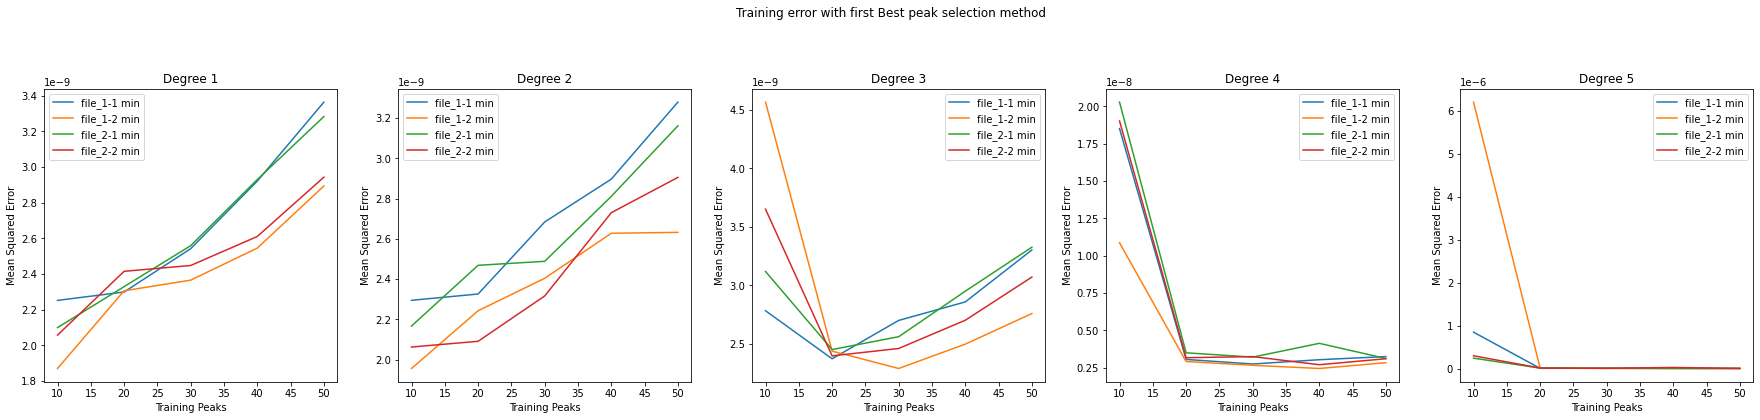

In [166]:
plotData = [testResultsBestPeaks1[0], testResultsBestPeaks1[1], testResultsBestPeaks2[0], testResultsBestPeaks2[1]]
labels = ["file_1-1 min", "file_1-2 min", "file_2-1 min", "file_2-2 min"]
plotBestPeaksResults(plotData, labels)

In [169]:
def plotPartitionsResults(dataArray, labels):
    a = len(set([p['partitions'] for p in dataArray[0]]))
    b = len(set(p['degree'] for p in dataArray[0]))
    fig, axis = plt.subplots(a,b,figsize=(30,30))
    fig.tight_layout(pad=3.0)
    #fig.subplots_adjust(top=1.65)
    fig.suptitle("Training error with Partitions selection method")
    for axs in axis:
        for ax in axs:
            ax.set_box_aspect(1)     
            ax.set(xlabel='Peaks per Partition', ylabel='Mean Squared Error')

    for i in range(a):
        for j in range(b):
            axis[i][j].set_title('Degree '+str(j+1))
            k = 0
            for d in dataArray:
                x = sorted(set(p['n'] for p in d))
                y = [p['mean_mse'] for p in d if p['degree'] == j+1 and p['partitions'] == i+2]
                axis[i][j].plot(x, y, label=labels[k])
                k+=1
            axis[i][j].legend()
    
    #Side notation on rows for indicating # of partitions
    rows = ['{} partitions'.format(row+2) for row in range(a)]
    pad = 30
    for ax, row in zip(axis[:,0], rows):
        ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                    xycoords=ax.yaxis.label, textcoords='offset points',
                    size='large', ha='right', va='center')
    fig.patch.set_facecolor('white')

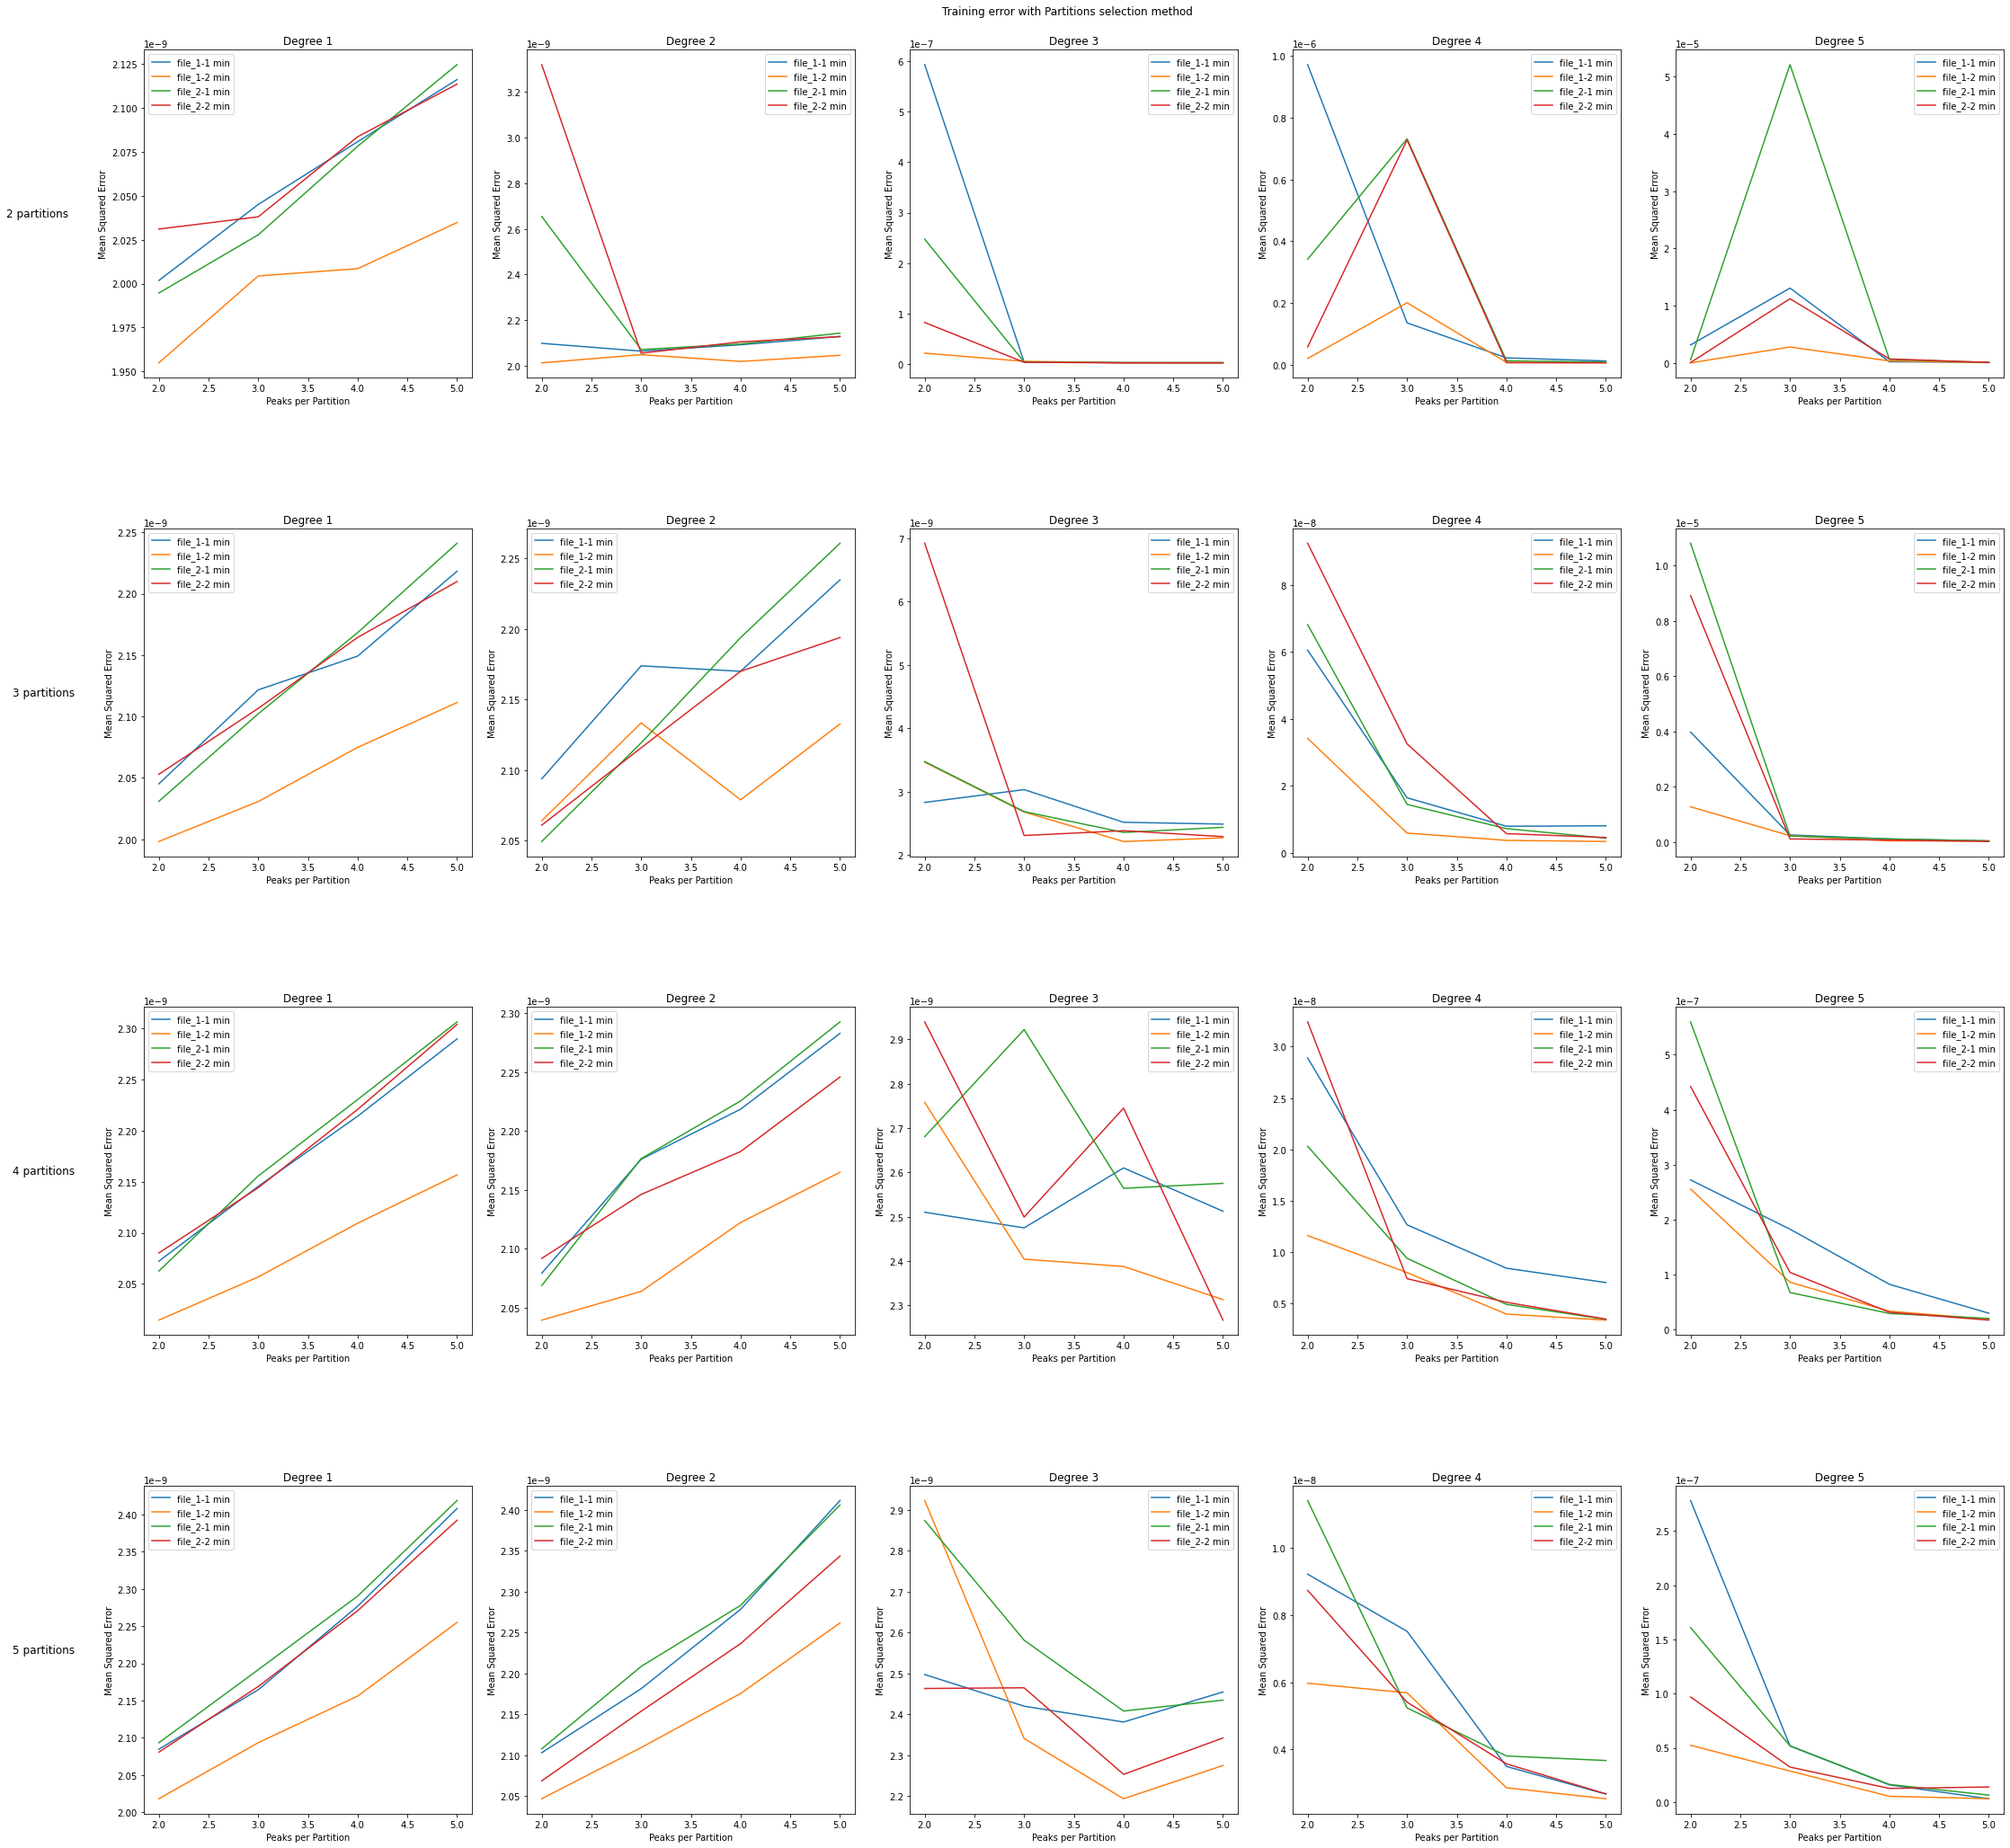

In [168]:
plotDataPartitions = [testResultsPartition1[0], testResultsPartition1[1], testResultsPartition2[0], testResultsPartition2[1]]
labels = ["file_1-1 min", "file_1-2 min", "file_2-1 min", "file_2-2 min"]
plotPartitionsResults(plotDataPartitions, labels)